# Limpieza de datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
df = pd.read_csv("archivos/Casos_Epidemiol_gicos_20250205.csv") #Leemos la base de datos

## Convertir fechas a formato datetime

df['Fecha_notificación'] = pd.to_datetime(df["Fecha_notificación"], format='%m/%d/%Y %H:%M:%S %p')
df['Fecha_contagio'] = pd.to_datetime(df["Fecha_contagio"], format='%m/%d/%Y %H:%M:%S %p')

# Eliminamos columnas no relevantes para el estudio

df.pop("Fecha_hospitalización")
df.pop("Semana_epidemiológica")
df.pop("Código_Nacionalidad")
df.pop("Otros_grupos_riesgo")

# Podemos rellenar información nula en ciertos campos no numericos con N/A
df["Unidad_generadora_datos"] = df["Unidad_generadora_datos"].fillna("Sin Dato")
df["Estrato_socioeconómico"] = df["Estrato_socioeconómico"].fillna("Sin Dato")


#Los años están escritos, como 2,024. vamos a eliminar dichas comas
df["Año"] = df["Año"].astype(str).str.replace(",","",regex=False)
df["Año_contagio"] = df["Año_contagio"].astype(str).str.replace(",","",regex=False)

#Hay filas en codigo de departamento con letras (error), por lo que vamos a hacer el cambio y que se eliminen

df["Codigo Departamento"] = pd.to_numeric(df["Codigo Departamento"] , errors="coerce")
df.dropna(inplace=True)


# Modificar elementos de "tipo de seguridad social": se reemplaza inicial por nombre completo:
# C: Contributivo
# E: Especial
# S: Subsidiado
# P: Particular
# N e I: No aplica

df['Tipo Seguridad Social'] = df['Tipo Seguridad Social'].replace({'C': 'Contributivo', 'E': 'Especial', 'S': 'Subsidiado', 'P':'Particular', 'N':'No aplica', 'I':'No aplica'})

# En la columna de sexos, reemplazamos para que esté escrito como femenino y masculino
df['Sexo_paciente'] = df['Sexo_paciente'].replace({'F': 'Femenino', 'M': 'Masculino'})

# Se corrige el formato en la columna de Estrato socioeconomico para que no estén estratos 1.0, 2.0, etc
    #El .astype(str) funciona para garantizar que se traten como strings, 
    # de lo contrario quedarían valores NaN
df['Estrato_socioeconómico'] = df['Estrato_socioeconómico'].astype(str).str.replace(".0" , '')

df.info() #Imprimimos la información del dataframe para identificar los datos y tipos de datos

<class 'pandas.core.frame.DataFrame'>
Index: 8626 entries, 0 to 8635
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Fecha_notificación          8626 non-null   datetime64[ns]
 1   Año                         8626 non-null   object        
 2   Edad_paciente               8626 non-null   int64         
 3   Nacionalidad                8626 non-null   object        
 4   Sexo_paciente               8626 non-null   object        
 5   Codigo Departamento         8626 non-null   float64       
 6   Código_Municipio            8626 non-null   int64         
 7   Tipo Seguridad Social       8626 non-null   object        
 8   Estrato_socioeconómico      8626 non-null   object        
 9   Discapacidad                8626 non-null   object        
 10  Desplazado                  8626 non-null   object        
 11  Migrante                    8626 non-null   object        
 1

# Análisis
Se analizará: 

        Edad: descriptiva
            Primera infancia: 0 a 5
            Niños: 6 a 12
            Adolescentes: 13 a 18
            Adultos: 19 a 60
            Adulto Mayor: 60 en adelante
        
        Nacionalidad: Grafica de barras

        Sexo: Grafico de torta

        Relación de sexo y grupo etario

        Grafica de distribución porcentual de tipo de afiliacion

        Grafica de estrato socioeconómico
            Agrupación de estrato socioeconómico Bajo (1,2,3) y otro grupo Alto (4,5,6) 
    
    Evento Reportado, en las 5 mas frecuentes, se agrupará por sexo, grupo etario y estrato socioeconomico

    Distribución de mortalidad porcentual (Certificado defunción)
        

Grupo Edad
Primera Infancia    1026
Niños                818
Adolescentes         643
Adultos             4467
Adulto Mayor        1672
Name: count, dtype: int64


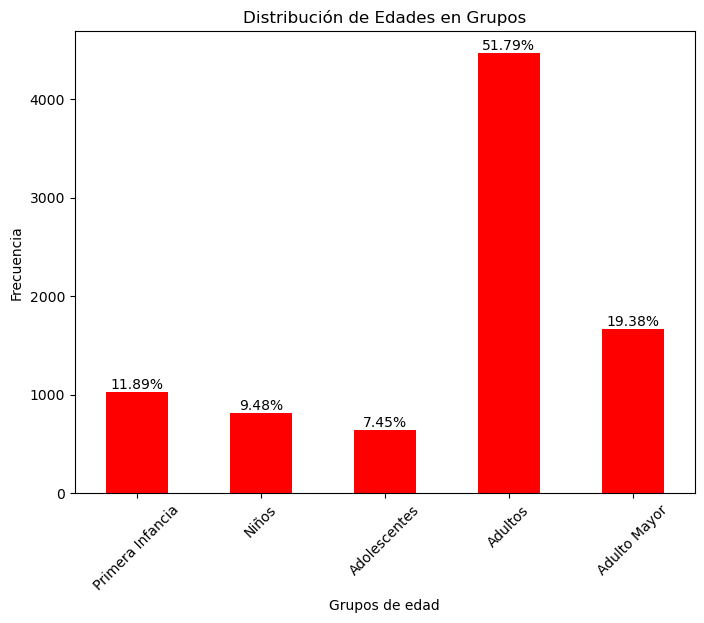

In [11]:
#### EDAD

# Supongamos que tu DataFrame se llama df y la columna de edades se llama "Edad"
# Definimos los límites para los grupos:
bins = [0, 6, 13, 18, 60, float('inf')]
labels = ['Primera Infancia', 'Niños', 'Adolescentes', 'Adultos', 'Adulto Mayor']

# Usamos pd.cut para crear la nueva columna "Grupo Edad"
df['Grupo Edad'] = pd.cut(df['Edad_paciente'], bins=bins, labels=labels, right=True)

# Verifica cómo quedaron los grupos:
print(df['Grupo Edad'].value_counts().sort_index())
# Contar la cantidad de registros en cada grupo de edad

conteo_grupos = df['Grupo Edad'].value_counts().sort_index()
total = conteo_grupos.sum()
# Graficar los conteos como un gráfico de barras
plt.figure(figsize=(8,6))
ax = conteo_grupos.plot(kind='bar', color='red',rot=45)
plt.title('Distribución de Edades en Grupos')
plt.xlabel('Grupos de edad')
plt.ylabel('Frecuencia')

for p in ax.patches:
    # Obtener la altura de la barra
    altura = p.get_height()
    # Calcular el porcentaje correspondiente
    porcentaje = 100 * altura / total
    # Colocar el texto en la posición central de la barra, un poco por encima de la altura
    ax.text(p.get_x() + p.get_width() / 2, altura + 1, f'{porcentaje:.2f}%', 
            ha='center', va='bottom', fontsize=10, color='black')

plt.show()

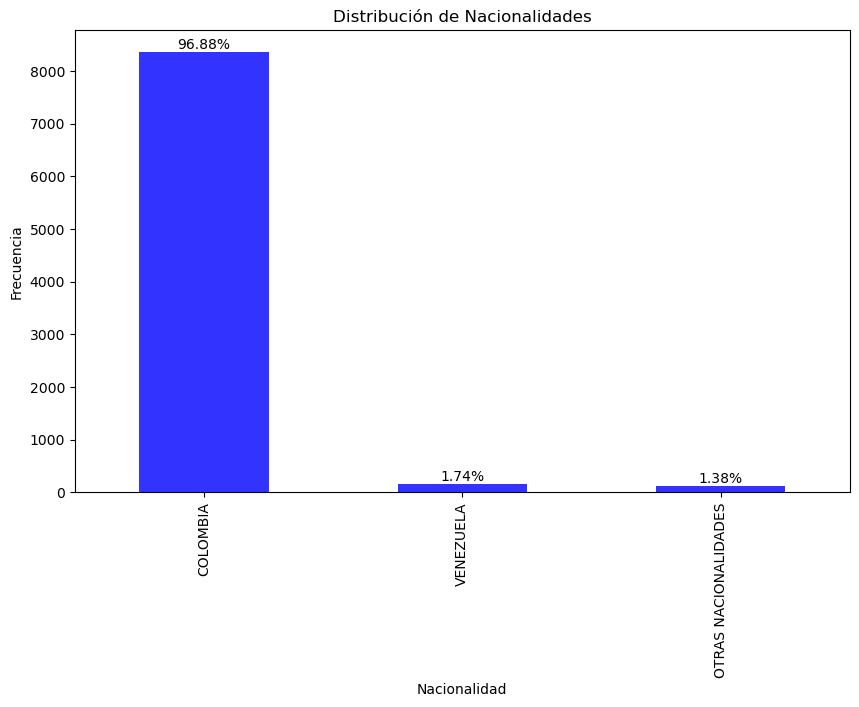

In [3]:
## NACIONALIDAD ##
# 1. Crear una nueva columna que agrupe las nacionalidades
# Convertimos a mayúsculas para evitar problemas de mayúsculas/minúsculas
# Si la nacionalidad es "COLOMBIA" o "VENEZUELA", se conserva; en caso contrario, se agrupa en "OTRAS NACIONALIDADES"
df['Nacionalidad_grupo'] = df['Nacionalidad'].str.upper().apply(
    lambda x: x if x in ['COLOMBIA', 'VENEZUELA'] else 'OTRAS NACIONALIDADES'
)

# 2. Obtener el conteo de cada grupo y reordenarlo según el orden deseado
conteo = df['Nacionalidad_grupo'].value_counts()
orden = ['COLOMBIA', 'VENEZUELA', 'OTRAS NACIONALIDADES']
conteo = conteo.reindex(orden, fill_value=0)

# 3. Calcular el total para obtener los porcentajes
total = conteo.sum()

# 4. Crear el gráfico de barras
plt.figure(figsize=(10,6))
ax = conteo.plot(kind='bar', color='blue', alpha=0.8)
plt.title('Distribución de Nacionalidades')
plt.xlabel('Nacionalidad')
plt.ylabel('Frecuencia')

# 5. Agregar etiquetas de porcentaje sobre cada barra
for p in ax.patches:
    altura = p.get_height()
    porcentaje = 100 * altura / total
    ax.text(p.get_x() + p.get_width()/2, altura + 1, f'{porcentaje:.2f}%', 
            ha='center', va='bottom', fontsize=10, color='black')

plt.show()


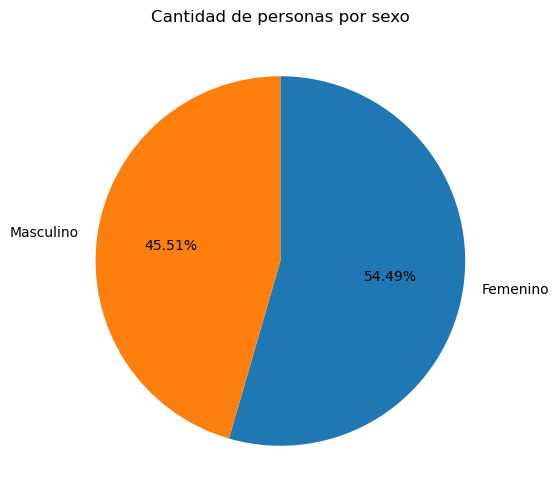

In [4]:
## SEXO ##
conteo = df['Sexo_paciente'].value_counts()
plt.figure(figsize=(6,6))  # Opcional: define el tamaño de la figura
conteo.plot(kind='pie' , autopct='%1.2f%%' , startangle=90 , counterclock=False , ylabel="")
plt.title('Cantidad de personas por sexo')
plt.show()

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_5712\4213320123.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conteo = df.groupby(['Grupo Edad', 'Sexo_paciente']).size().unstack()


<Figure size 1000x600 with 0 Axes>

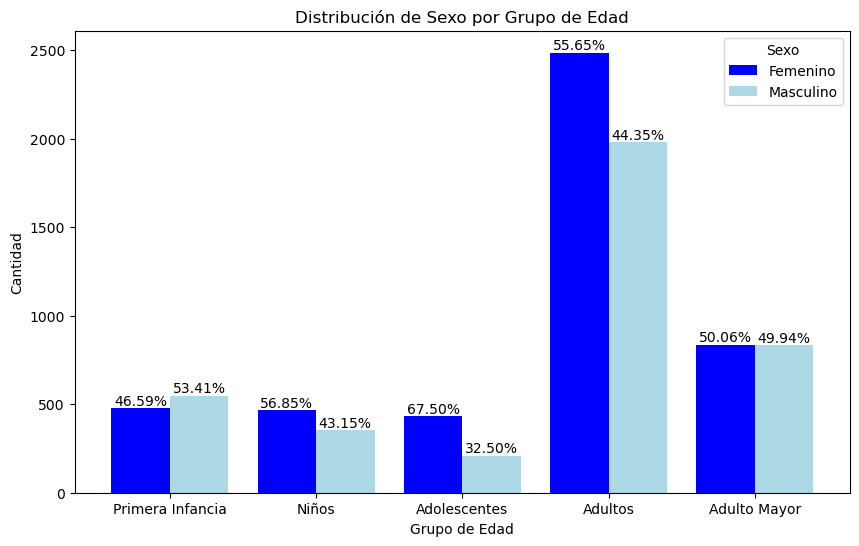

In [5]:
## SEXO POR GRUPO ETARIO ##
import pandas as pd
import matplotlib.pyplot as plt

# 1. Agrupar los datos y contar las ocurrencias
# Esto crea un DataFrame donde las filas son los grupos etarios y las columnas, los sexos.
conteo = df.groupby(['Grupo Edad', 'Sexo_paciente']).size().unstack()

# 2. Calcular los porcentajes por grupo (por fila)
# Para cada grupo (fila) se divide cada valor por la suma de la fila y se multiplica por 100.
porcentajes = conteo.div(conteo.sum(axis=1), axis=0) * 100

# 3. Graficar el barplot (agrupado)
plt.figure(figsize=(10,6))
ax = conteo.plot(kind='bar', width=0.8, figsize=(10,6), rot=0, color=['blue','lightblue'])

plt.title('Distribución de Sexo por Grupo de Edad')
plt.xlabel('Grupo de Edad')
plt.ylabel('Cantidad')

# 4. Agregar etiquetas de porcentaje sobre cada barra
# Matplotlib organiza las barras en "containers", uno por cada serie (sexo).
# Iteramos sobre cada container para etiquetar cada barra con el porcentaje correspondiente.
for j, container in enumerate(ax.containers):
    # j es el índice de la serie (columna), que corresponde al sexo.
    # Para cada barra en ese container, obtenemos la fila (grupo) correspondiente.
    labels = [f'{porcentajes.iloc[i, j]:.2f}%' for i in range(len(porcentajes))]
    ax.bar_label(container, labels=labels, fontsize=10)

plt.legend(title='Sexo')
plt.show()

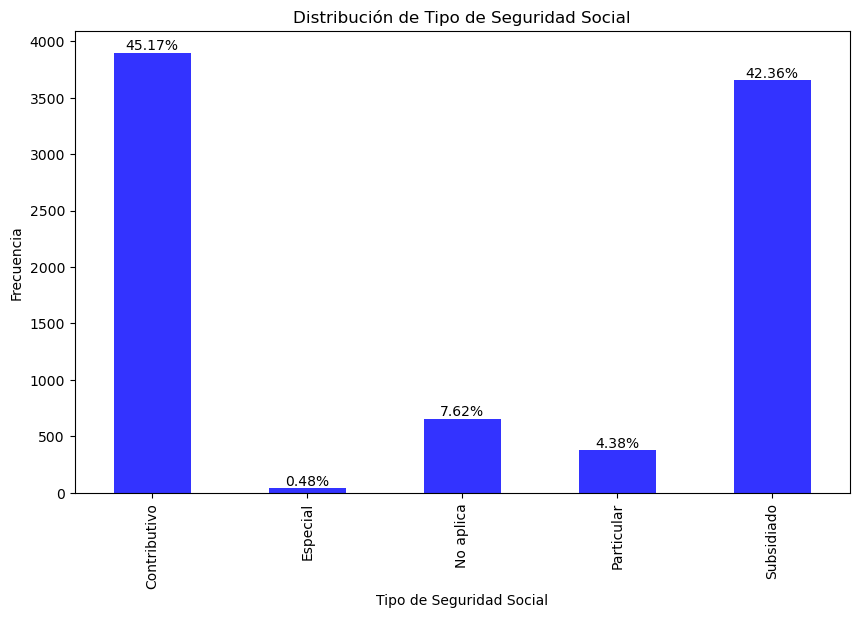

In [6]:
## TIPO DE AFILIACIÓN
# 1. Contar las ocurrencias de cada valor en la columna "Tipo Seguridad Social"
conteo = df['Tipo Seguridad Social'].value_counts().sort_index()
# sort_index() es opcional y sirve para ordenar las barras alfabéticamente o por el orden deseado.

# 2. Calcular el total de registros (para obtener los porcentajes)
total = conteo.sum()

# 3. Crear el gráfico de barras
plt.figure(figsize=(10,6))
ax = conteo.plot(kind='bar', color='blue', alpha=0.8)
plt.title('Distribución de Tipo de Seguridad Social')
plt.xlabel('Tipo de Seguridad Social')
plt.ylabel('Frecuencia')

# 4. Agregar etiquetas de porcentaje sobre cada barra
for p in ax.patches:
    altura = p.get_height()                 # Obtiene el valor de la barra (frecuencia)
    porcentaje = 100 * altura / total         # Calcula el porcentaje
    # Coloca el texto centrado sobre la barra, un poco por encima de la altura
    ax.text(p.get_x() + p.get_width() / 2, altura + 1, f'{porcentaje:.2f}%', 
            ha='center', va='bottom', fontsize=10, color='black')
plt.show()

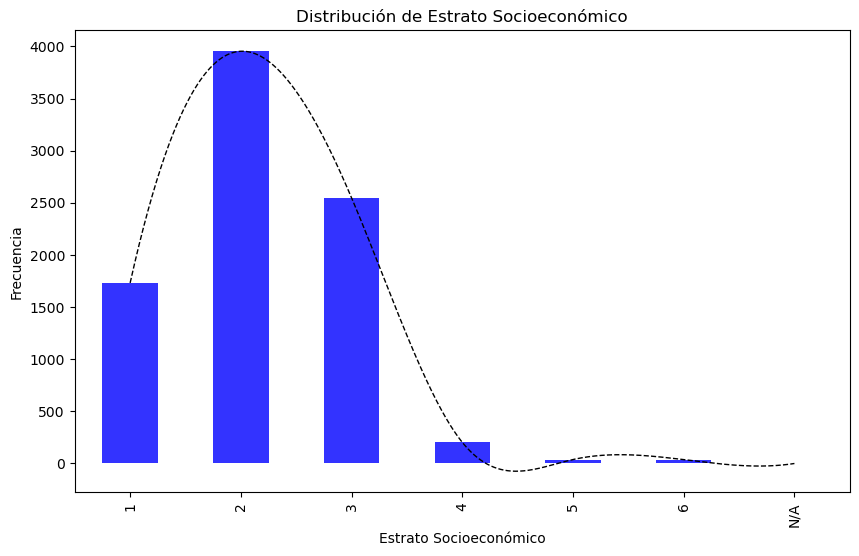

In [7]:
## ESTRATO EN GENERAL ##
conteo = df['Estrato_socioeconómico'].value_counts()
orden = ['1', '2', '3', '4', '5', '6', 'N/A']
conteo = conteo.reindex(orden, fill_value=0)

plt.figure(figsize=(10,6))
ax = conteo.plot(kind='bar', color='blue', alpha=0.8)
ax.set_xlabel('Estrato Socioeconómico')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribución de Estrato Socioeconómico')

# Para trazar la línea suavizada:
# Primero definimos los puntos x (la posición de cada barra) y y (los valores de conteo)
x = np.array(range(len(conteo)))
y = conteo.values

# Creamos un nuevo arreglo de puntos x con más resolución para la línea suave.
x_suave = np.linspace(x.min(), x.max(), 20**4)  # 300 puntos para suavizar la curva

# Usamos un spline cúbico para interpolar los puntos originales.
spline = make_interp_spline(x, y, k=3)  # k=3 para un spline cúbico
y_suave = spline(x_suave)

# Dibujamos la línea suavizada sobre el barplot
ax.plot(x_suave, y_suave, color='k', linestyle='--', linewidth=1, label='Tendencia Suavizada')

plt.show()


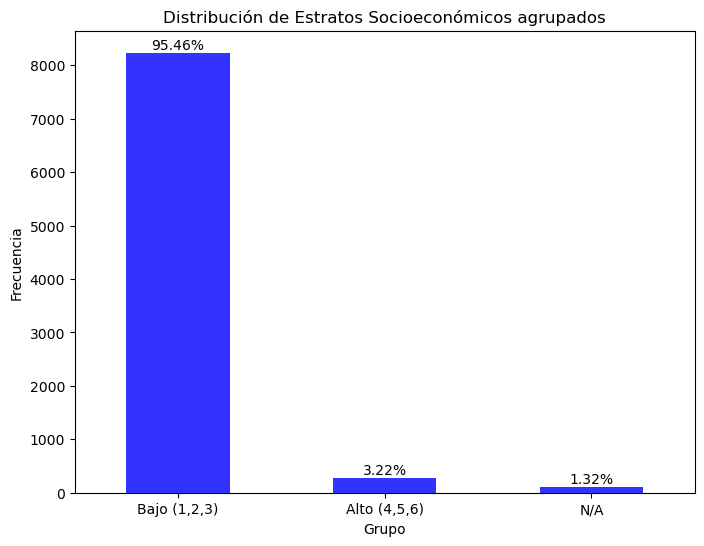

In [8]:
## ESTRATO AGRUPADO ##
# 1. Crear una nueva columna 'Grupo_Estrato' que agrupe los estratos:
# - 'Bajo' para estratos 1, 2 y 3
# - 'Alto' para estratos 4, 5 y 6
# - Si el valor es diferente (por ejemplo, "N/A"), se conserva como "N/A"
def asignar_grupo(estrato):
    if estrato in ['1', '2', '3']:
        return 'Bajo (1,2,3)'
    elif estrato in ['4', '5', '6']:
        return 'Alto (4,5,6)'
    else:
        return 'N/A'

df['Grupo_Estrato'] = df['Estrato_socioeconómico'].apply(asignar_grupo)

# 2. Contar cuántas veces aparece cada grupo
conteo = df['Grupo_Estrato'].value_counts()

# Para asegurarnos del orden deseado (Bajo, Alto y luego N/A)
orden = ['Bajo (1,2,3)', 'Alto (4,5,6)', 'N/A']
conteo = conteo.reindex(orden, fill_value=0)

# 3. Calcular el total y los porcentajes para cada grupo
total = conteo.sum()
porcentajes = 100 * conteo / total

# 4. Graficar un barplot con los porcentajes anotados sobre cada barra
plt.figure(figsize=(8,6))
ax = conteo.plot(kind='bar', color='blue', alpha=0.8, rot=0)
plt.title('Distribución de Estratos Socioeconómicos agrupados')
plt.xlabel('Grupo')
plt.ylabel('Frecuencia')

# Agregar las etiquetas de porcentaje sobre cada barra
for p in ax.patches:
    altura = p.get_height()
    porcentaje = 100 * altura / total
    ax.text(p.get_x() + p.get_width() / 2, altura + 1, f'{porcentaje:.2f}%', 
            ha='center', va='bottom', fontsize=10, color='black')

plt.show()